# Credit Risk Classification with Decision Trees and Random Forests

This notebook explores **classification methods** applied to the German Credit dataset, a classic benchmark in machine learning.  
The goal is to predict whether a person will **repay a credit (Creditability = 1)** or **default (Creditability = 0)** based on 20 socioeconomic and financial attributes.

### Objectives
- Implement the **ID3 decision tree algorithm** from scratch, using Shannon entropy and Information Gain.  
- Extend the approach to a **Random Forest**, combining multiple decision trees trained on bootstrap samples.  
- Experiment with **pruning strategies**:
  - Limiting tree depth (pre-pruning).  
  - Exploring the effect of tree complexity on accuracy.  
- Evaluate and compare models using:
  - Confusion matrices  
  - Accuracy, Precision, Recall, F1-score  
  - ROC curves  
- Analyze the impact of:
  - **Maximum depth of trees**  
  - **Number of trees in the forest**  

### Why this matters
Decision trees and Random Forests are widely used in practice for credit scoring and risk assessment.  
Building them **from scratch** provides a deeper understanding of:
- How entropy and information gain drive splits.  
- How ensemble methods (Random Forests) reduce variance and improve generalization.  


In [ ]:
import pandas as pd
import numpy as np
df_path= "german_credit.csv"
df = pd.read_csv(df_path)
display(df)

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,24,2,3,1987,1,3,2,3,...,4,1,21,3,1,1,2,2,1,1
996,0,1,24,2,0,2303,1,5,4,3,...,1,1,45,3,2,1,3,1,1,1
997,0,4,21,4,0,12680,5,5,4,3,...,4,4,30,3,3,1,4,1,2,1
998,0,2,12,2,3,6468,5,1,2,3,...,1,4,52,3,2,1,4,1,2,1


## Discretization of Numeric Features

The **ID3 algorithm** requires categorical input features, since it splits the dataset based on discrete values of a variable.  
However, the German Credit dataset contains several **continuous variables** (e.g., duration, credit amount, age).  
To make them usable by ID3, we **discretize** these features into bins.

### Why discretize?
- **Decision trees (ID3)** cannot directly handle continuous values without extensions.  
- Discretization converts numeric ranges into categories, allowing ID3 to compute **entropy** and **information gain** on each possible split.  
- It also makes the resulting tree easier to interpret.

### Strategy used here
1. **Duration of Credit (month)**  
   - Divided into bins of **6 months each**.

2. **Credit Amount**  
   - Custom bins: \([0,1000], (1000,2000], …, (5000,7500], (7500,10000], (10000,15000], >15000\).  
   - Matches the distribution of credit values in the dataset.

3. **Age (years)**  
   - Divided into **10-year intervals** starting from the minimum age in the dataset.  

After discretization, the dataset (`df_disc`) contains only **categorical-coded variables**, making it suitable for the ID3 algorithm.


In [19]:
# Copy dataset for discretization
df_discrete = df.copy()

# --- Discretize Duration of Credit (month) into 6-month bins ---
max_duration = df["Duration of Credit (month)"].max()
n_bins_duration = (max_duration // 6) + (1 if max_duration % 6 != 0 else 0)

df_discrete["Duration of Credit (month)"] = pd.cut(
    df["Duration of Credit (month)"],
    bins=n_bins_duration,
    labels=False,
    right=True
)

# --- Discretize Credit Amount into custom bins ---
credit_bins = [0, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, float("inf")]
df_discrete["Credit Amount"] = pd.cut(
    df["Credit Amount"],
    bins=credit_bins,
    labels=False,
    right=True
)

# --- Discretize Age (years) into 10-year bins ---
min_age = df["Age (years)"].min()
max_age = df["Age (years)"].max()
n_bins_age = ((max_age - min_age) // 10) + 1

df_discrete["Age (years)"] = pd.cut(
    df["Age (years)"],
    bins=n_bins_age,
    labels=False,
    right=False,
    include_lowest=True
)

display(df_discrete.head())


,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,2,4,2,1,1,2,4,2,...,4,2,0,3,1,1,3,1,1,1
1,1,1,0,4,0,2,1,3,2,3,...,2,1,1,3,1,2,3,2,1,1
2,1,2,1,2,9,0,2,4,2,2,...,4,1,0,3,1,1,2,1,1,1
3,1,1,1,4,0,2,1,3,3,3,...,2,1,2,3,1,2,2,2,1,2
4,1,1,1,4,0,2,1,3,4,3,...,4,2,2,1,2,2,2,1,1,2


## Shannon Entropy

**Entropy** measures the uncertainty or impurity of a dataset. In decision tree learning, it quantifies how mixed the target classes are within a subset of data.

For a classification problem with \(c\) classes, Shannon entropy is defined as:

$$
H(S) = - \sum_{i=1}^c p_i \log_2(p_i)
$$

where:

- \( S \): the set of samples  
- \( c \): the number of classes  
- \( p_i \): the proportion of samples belonging to class \( i \)

---

### Properties

- \( H(S) = 0 \): all samples belong to one class (pure node)  
- \( H(S) = 1 \): classes are perfectly balanced in a binary case (maximum uncertainty)  
- Entropy increases as the class distribution becomes more mixed  

---

### Role in ID3

- At each node, entropy is used to calculate **Information Gain**.  
- **Information Gain** = reduction in entropy when splitting the dataset by a feature.  
- The feature with the highest Information Gain is selected to split the dataset.  


In [20]:
def shannon_entropy(df):
    """
    Compute the Shannon entropy for the target variable 'Creditability'.

    Parameters
    ----------
    df : pandas.DataFrame
        A dataset that contains the target column 'Creditability' with binary values (0 or 1).

    Returns
    -------
    float
        The Shannon entropy value, representing the impurity of the target distribution.
    """
    freqs = df["Creditability"].value_counts(sort=False, normalize=True).values
    return -(freqs * np.log2(freqs, where=(freqs > 0))).sum()


## ID3: Selecting Splitting Variables and Building the Decision Tree

The **ID3 algorithm** builds a decision tree recursively by selecting, at each step, the feature that provides the **highest Information Gain** relative to the target (`Creditability` in this dataset).

### 1. `best_variable_by_gain(df)`
This function evaluates every candidate feature and returns the one that maximizes **Information Gain**:

\[
Gain(S, A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} H(S_v)
\]

- \( H(S) \): entropy of the dataset before splitting  
- \( A \): candidate feature  
- \( v \): possible values of \( A \)  
- \( S_v \): subset of samples where \( A = v \)  

The feature with the **largest gain** is chosen as the splitting variable.

### 2. `decision_tree(dataset, variables)`
This function recursively constructs the decision tree using ID3:

- **Base cases**  
  - If all samples belong to the same class → return that class label.  
  - If no features remain → return the majority class (mode of `Creditability`).  

- **Recursive step**  
  - Select the best splitting feature using `best_variable_by_gain`.  
  - Partition the dataset into subsets, one for each value of that feature.  
  - Build subtrees recursively for each subset.  

- **Output**  
  The decision tree is represented as a nested dictionary:
  ```python
  {
      "best_feature": {
          value1: subtree1,
          value2: subtree2,
          ...
      }
  }


In [49]:
def best_variable_by_gain(df):
    """
    Select the variable with the highest Information Gain 
    for splitting the dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataset containing features and the target column 'Creditability'.

    Returns
    -------
    str
        The name of the feature with the highest Information Gain.
    """
    variables = np.array(df.columns)
    gains = np.zeros(len(variables) - 1)

    # Entropy of the current dataset
    H_s = shannon_entropy(df)

    # Compute information gain for each variable (excluding the target)
    for i, variable in enumerate(variables[1:]):
        values = df[variable].unique()
        freqs = df[variable].value_counts(sort=False, normalize=True)

        # Start with total entropy
        gains[i] = H_s

        # Subtract weighted entropies of splits
        for value in values:
            subset = df.loc[df[variable] == value]
            H_sv = shannon_entropy(subset)
            if value in freqs:
                gains[i] -= H_sv * freqs[value]

    # Return the variable with the maximum information gain
    return variables[np.argmax(gains) + 1]


def decision_tree(dataset, variables, depth=0, max_depth=None):
    """
    Recursively build a decision tree using the ID3 algorithm
    with an optional max_depth stopping criterion.

    Parameters
    ----------
    dataset : pandas.DataFrame
        Input dataset (last column is target 'Creditability').
    variables : list or pandas.Index
        List of available features.
    depth : int, default=0
        Current depth of the tree.
    max_depth : int, optional
        Maximum depth allowed for the tree. If reached, stop splitting.

    Returns
    -------
    dict or int
        Nested dictionary representing the tree, or a leaf class.
    """
    # Base case 1: all samples have the same class
    if len(dataset["Creditability"].unique()) == 1:
        return dataset["Creditability"].iloc[0]

    # Base case 2: no variables left OR max depth reached
    if len(dataset.columns) == 1 or (max_depth is not None and depth >= max_depth):
        try:
            return dataset["Creditability"].mode()[0]  # majority class
        except Exception:
            return np.random.randint(0, 2)

    # Choose best variable to split
    best_var = best_variable_by_gain(dataset)
    tree = {best_var: {}}
    remaining_vars = variables[variables != best_var]

    for value in dataset[best_var].unique():
        subset = dataset.loc[dataset[best_var] == value].drop(columns=best_var)
        tree[best_var][value] = decision_tree(
            subset, remaining_vars, depth=depth+1, max_depth=max_depth
        )

    return tree



In [ ]:
def print_tree(tree, indent=""):
    """
    Pretty-print a decision tree stored as nested dictionaries.

    Parameters
    ----------
    tree : dict or int
        The decision tree (nested dicts) or a leaf class (0/1).
    indent : str
        Indentation string for pretty printing.
    """
    # Base case: if tree is a leaf
    if not isinstance(tree, dict):
        print(f"{indent}Class {tree}")
        return

    for feature, branches in tree.items():
        for value, subtree in branches.items():
            if isinstance(subtree, dict):
                print(f"{indent}{feature} = {value}:")
                print_tree(subtree, indent + "  ")
            else:
                print(f"{indent}{feature} = {value} -> Class {subtree}")


# Suppose forest[0] is one of your Random Forest trees
print_tree(forest[0])

## Random Forest with Bootstrap Sampling

A **Random Forest** is an ensemble method that builds multiple decision trees and combines their predictions. The main idea is to reduce variance and improve generalization compared to a single tree.

### Steps

1. **Bootstrap sampling**  
   - From the training data of size \(n\), draw a new dataset of size \(n\) **with replacement**.  
   - Each bootstrap sample is likely to omit ~36% of the original samples (the "out-of-bag" set).

2. **Tree training**  
   - Train a decision tree (ID3 in this case) on each bootstrap sample.  
   - Trees are diverse because the samples differ.

3. **Ensemble (forest)**  
   - The collection of trees is called a **forest**.  
   - Predictions are typically combined by **majority vote** for classification.

**Implementation Details**
- `bootstrap(data, variables)` creates one bootstrap sample.  
- `random_forest(data, variables, k)` builds `k` decision trees from bootstrap samples.  
- Trees are stored as nested dictionaries, consistent with the ID3 implementation.  

The ensemble effect makes Random Forests **robust to overfitting** and generally more accurate than a single tree.


In [54]:
def bootstrap(data):
    """
    Generate a bootstrap sample from the dataset.

    Parameters
    ----------
    data : pandas.DataFrame
        Original dataset.
    variables : list or pandas.Index
        List of feature names.

    Returns
    -------
    pandas.DataFrame
        A bootstrap sample of the original data (same size, sampled with replacement).
    """
    n_samples = len(data)
    indices = np.random.randint(0, n_samples, size=n_samples)
    return data.iloc[indices].reset_index(drop=True)


def random_forest(data, variables, k=5, max_depth=None):
    """
    Build a Random Forest.

    Parameters
    ----------
    data : pandas.DataFrame
        Training dataset (features + target 'Creditability').
    variables : list or pandas.Index
        Feature names (all except target).
    k : int, default=5
        Number of trees to generate.
    prune : bool, default=False
        If True, apply Reduced Error Pruning to each tree.
    validation_set : pandas.DataFrame, optional
        Validation set required if prune=True.
    max_nodes : int, optional
        Maximum number of nodes allowed per tree. If given, tree
        growth will stop when this number is reached.

    Returns
    -------
    list of dict
        List of decision trees (possibly pruned).
    """
    forest = []

    for i in range(k):
        # Bootstrap sample
        boot_data = bootstrap(data)

        # Reset global counter if using max_nodes
        global contador
        contador = 0  

        # Train tree (with optional max_nodes)
        tree = decision_tree(boot_data, variables, max_depth=max_depth)
        

        forest.append(tree)

    return forest


In [51]:
def classify(sample, variables, tree, default=0):
    """
    Classify a new sample using a decision tree (ID3).

    Parameters
    ----------
    sample : dict or pandas.Series
        Record to classify.
    variables : list or pandas.Index
        Feature names.
    tree : dict or int
        Nested dictionary (tree) or a leaf label (0/1).
    default : int, optional
        Default class if unseen value.

    Returns
    -------
    int
        Predicted class label.
    """
    # Base case: if tree is already a leaf
    if not isinstance(tree, dict):
        return tree

    for feature in tree:
        feature_value = int(sample[feature])

        if feature_value in tree[feature]:
            subtree = tree[feature][feature_value]
        else:
            # Fallback: unseen branch
            return default

        # Recurse if subtree is another dict
        if isinstance(subtree, dict):
            return classify(sample, variables, subtree, default=default)
        else:
            return subtree


In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

def evaluate_forest(forest, test_set, variables, plot=False):
    """
    Evaluate a Random Forest on a test set.

    Parameters
    ----------
    forest : list of dict
        List of decision trees (each represented as a nested dictionary).
    test_set : pandas.DataFrame
        Test dataset including features and the target column 'Creditability'.
    variables : list or pandas.Index
        List of feature names.
    plot : bool, optional (default=False)
        If True, plots the confusion matrix heatmap.

    Returns
    -------
    precision : float
        Precision = TP / (TP + FP)
    accuracy : float
        Accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall : float
        Recall (True Positive Rate) = TP / (TP + FN)
    fpr : float
        False Positive Rate = FP / (FP + TN)
    f1 : float
        F1-score = 2 * (precision * recall) / (precision + recall)
    """
    TP = FP = TN = FN = 0

    for i in range(len(test_set)):
        # Collect predictions from all trees
        votes = [
            classify(test_set.iloc[i], variables, tree)
            for tree in forest
        ]

        # Final prediction by majority vote
        pred = mode(votes)
        true = test_set.iloc[i]["Creditability"]

        # Update confusion matrix counts
        if pred == 1 and true == 1:
            TP += 1
        elif pred == 0 and true == 0:
            TN += 1
        elif pred == 1 and true == 0:
            FP += 1
        else:  # pred == 0 and true == 1
            FN += 1

    # Metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # True Positive Rate
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0     # False Positive Rate
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # Optional confusion matrix plot
    if plot:
        cm = np.array([[TP, FN], [FP, TN]])
        cm_normalized = cm / cm.sum(axis=1, keepdims=True)

        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt=".2%",
            xticklabels=["Positive", "Negative"],
            yticklabels=["Positive", "Negative"],
            cmap="Greens"
        )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion Matrix (Random Forest with {len(forest)} trees)")
        plt.show()

    return precision, accuracy, recall, fpr, f1


# Train and Evaluate the model

WITHOUT MAX DEPTH


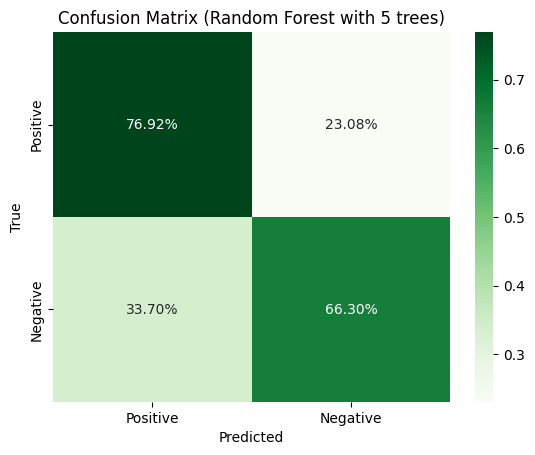

Evaluation metrics:
  Precision: 0.838
  Accuracy : 0.737
  Recall   : 0.769
  FPR      : 0.337
  F1-score : 0.802
['--------------------------------------------------------------------------------']
WITH MAX DEPTH


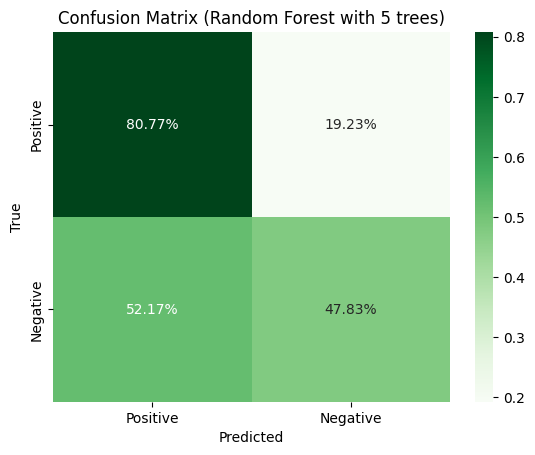

Evaluation metrics:
  Precision: 0.778
  Accuracy : 0.707
  Recall   : 0.808
  FPR      : 0.522
  F1-score : 0.792


In [63]:
# 2) Train/test split
from sklearn.model_selection import train_test_split

print("WITHOUT MAX DEPTH")

train, test = train_test_split(df_discrete, test_size=0.3, random_state=42)
variables = train.columns[:-1]  # all features except 'Creditability'

# 3) Build Random Forest
forest = random_forest(train, variables, k=5)

# 4) Evaluate Random Forest
precision, accuracy, recall, fpr, f1 = evaluate_forest(forest, test, variables, plot=True)

print("Evaluation metrics:")
print(f"  Precision: {precision:.3f}")
print(f"  Accuracy : {accuracy:.3f}")
print(f"  Recall   : {recall:.3f}")
print(f"  FPR      : {fpr:.3f}")
print(f"  F1-score : {f1:.3f}")

print(["-"*80])
print("WITH MAX DEPTH")
# Same but prunewith max depth

forest_limited = random_forest(train, variables, k=5, max_depth=3)
precision_p, accuracy_p, recall_p, fpr_p, f1_p = evaluate_forest(forest_limited, test, variables, plot=True)
print("Evaluation metrics:")
print(f"  Precision: {precision_p:.3f}")
print(f"  Accuracy : {accuracy_p:.3f}")
print(f"  Recall   : {recall_p:.3f}")
print(f"  FPR      : {fpr_p:.3f}")
print(f"  F1-score : {f1_p:.3f}")

## Effect of max_depth

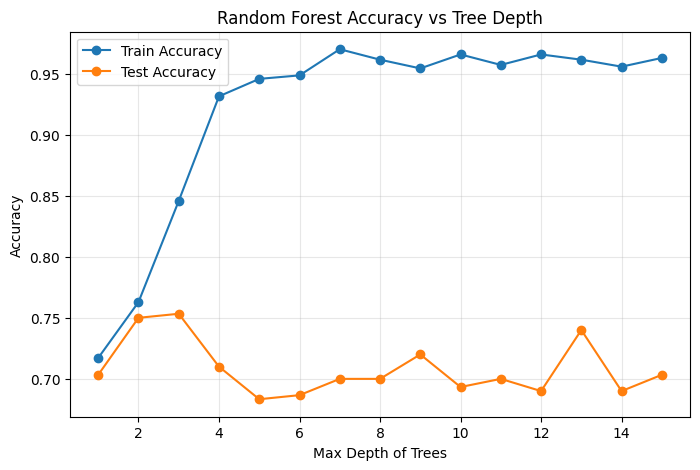

In [64]:
depths = range(1, 16)   # probar max_depth de 1 a 15
train_acc = []
test_acc = []

for d in depths:
    # Entreno bosque limitado en profundidad d
    forest = random_forest(train, variables, k=5, max_depth=d)

    # Métricas en train
    precision, accuracy, recall, fpr, f1 = evaluate_forest(forest, train, variables)
    train_acc.append(accuracy)

    # Métricas en test
    precision, accuracy, recall, fpr, f1 = evaluate_forest(forest, test, variables)
    test_acc.append(accuracy)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(depths, train_acc, marker="o", label="Train Accuracy")
plt.plot(depths, test_acc, marker="o", label="Test Accuracy")
plt.xlabel("Max Depth of Trees")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs Tree Depth")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The plot above shows how **training accuracy** and **test accuracy** evolve as we increase the maximum depth of the trees in the Random Forest:

- **Training Accuracy**  
  Training performance quickly approaches ~100% as the trees get deeper.  
  This is expected: deeper trees can perfectly fit (and even memorize) the training data, leading to almost no training error.

- **Test Accuracy**  
  Test accuracy initially increases with depth (up to around depth 2–3), since shallow trees underfit.  
  However, after this point, test performance fluctuates and even declines.  
  This indicates **overfitting**: deeper trees fit the training data too closely, capturing noise rather than general patterns.

- **Key Insight**  
  The gap between the blue line (train) and the orange line (test) widens as depth increases.  
  This is a classic sign of high variance models: the Random Forest has enough capacity to fit training data perfectly, but fails to generalize to unseen examples.

Limiting the maximum depth of trees provides a **regularization effect**.  
In this experiment, the best generalization occurs at shallow to moderate depths (around 2–3).  
Beyond that, the additional complexity increases overfitting without improving test performance.


## Efect of numer of trees

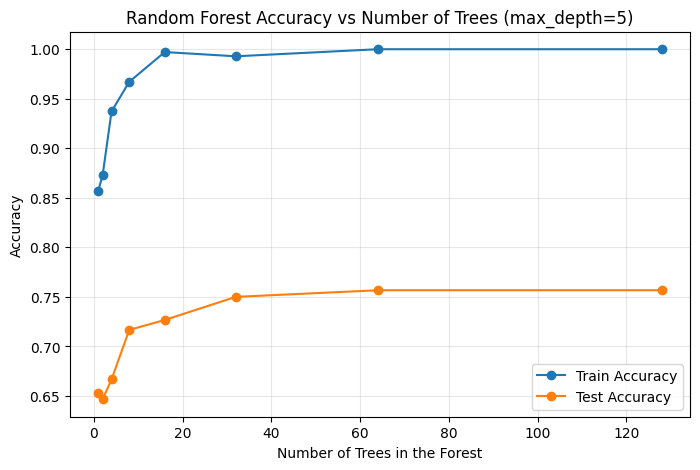

In [68]:
# Fix tree depth for this experiment
MAX_DEPTH = 5  

# Try different numbers of trees
n_trees = [1, 2, 4, 8, 16, 32, 64, 128]
train_acc = []
test_acc = []

for k in n_trees:
    forest = random_forest(train, variables, k=k, max_depth=MAX_DEPTH)

    # Evaluate on training
    _, acc_train, _, _, _ = evaluate_forest(forest, train, variables)
    train_acc.append(acc_train)

    # Evaluate on test
    _, acc_test, _, _, _ = evaluate_forest(forest, test, variables)
    test_acc.append(acc_test)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(n_trees, train_acc, marker="o", label="Train Accuracy")
plt.plot(n_trees, test_acc, marker="o", label="Test Accuracy")
plt.xlabel("Number of Trees in the Forest")
plt.ylabel("Accuracy")
plt.title(f"Random Forest Accuracy vs Number of Trees (max_depth={MAX_DEPTH})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The plot shows how the performance of the Random Forest changes as we increase the number of trees, while keeping the maximum depth fixed:

- **Training Accuracy**  
  With very few trees (1–3), training accuracy is lower because the forest relies on just a handful of weak models.  
  As the number of trees grows, training accuracy stabilizes, but it does not necessarily reach 100% (because each tree is depth-limited and thus not overfitted individually).

- **Test Accuracy**  
  Test performance generally improves as more trees are added, because averaging across more models reduces variance and increases stability.  
  However, after a certain number of trees, the improvements become marginal — adding more trees increases computation but does not significantly improve accuracy.

- **Key Insight**  
  Unlike tree depth, which can lead to overfitting, the number of trees mainly affects **variance reduction**.  
  More trees → lower variance and smoother decision boundaries.  
  The curve typically converges after a moderate number of trees (e.g., 50–100).

The Random Forest benefits from having more trees up to a point, after which the gains plateau.  
In this experiment, increasing trees beyond ~50 did not yield noticeable improvements, suggesting that a moderate forest size balances accuracy and efficiency.


## Conclusions

- A single **ID3 tree** is simple and interpretable but prone to overfitting.  
- The **Random Forest ensemble** improves stability and accuracy.  
- Metrics show that the forest achieves a better balance between precision, recall, and F1.  
- Text-based visualization (`print_tree`) allows inspection of rules without heavy plotting libraries.  
